In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sachinkumar413_diabetic_retinopathy_dataset_path = kagglehub.dataset_download('sachinkumar413/diabetic-retinopathy-dataset')

print('Data source import complete.')


100%|██████████| 350M/350M [00:02<00:00, 127MB/s] 

Extracting files...


Data source import complete.


# About Dataset

<img src="https://th.bing.com/th/id/R.a672705de96542b9f120f7dabc9dbf9a?rik=iEzFJf%2blYr0Acw&riu=http%3a%2f%2fpediatricophthalmologypa.com%2fwp-content%2fuploads%2f2014%2f01%2fDiabetic-Retinopathy-Blindness.png&ehk=vb2qvyFjNGpv6VGQWbnvpiIgpGtoCRrrPZKkJ4DMNMc%3d&risl=&pid=ImgRaw&r=0" alt="centered image" image align ="right" class="sc-hTnXLe UAvdY"
     width = '500'
     height ='1000'/>

## Total Class Labels = 5

## Total Images = 2750

### 1. Healthy (Not DR) = 1000

### 2. Mild DR = 370

### 3. Moderate DR = 900

### 4. Proliferative DR = 290

### 5. Severe DR = 190

### DR: Diabetic Retinopathy



>

# 1 Import libraries

In [2]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

All done


In [9]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR')

In [ ]:
# Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
# data = os.listdir(Path_data)
Healthy = ('/content/drive/MyDrive/MCA PROJECTS/archive/Healthy')
Mild = ('/content/drive/MyDrive/MCA PROJECTS/archive/Mild DR')
Moderate = ('/content/drive/MyDrive/MCA PROJECTS/archive/Moderate DR')
Proliferate = ('/content/drive/MyDrive/MCA PROJECTS/archive/Proliferate DR')
Severe = ('/content/drive/MyDrive/MCA PROJECTS/archive/Severe DR')

In [11]:
# print("classes names :", (data), "\n______________________________\n")
# print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

Number of Healty images : 51 
______________________________

Number of Mild images : 51 
______________________________

Number of Moderate images : 55 
______________________________

Number of Proliferate images : 58 
______________________________

Number of severe images : 53 
______________________________



In [13]:
# Get Paths
Healthy_path = '/content/drive/MyDrive/MCA PROJECTS/archive/Healthy'
Mild_path = '/content/drive/MyDrive/MCA PROJECTS/archive/Mild DR'
Moderate_path = '/content/drive/MyDrive/MCA PROJECTS/archive/Moderate DR'
Proliferate_path = '/content/drive/MyDrive/MCA PROJECTS/archive/Proliferate DR'
Severe_path = '/content/drive/MyDrive/MCA PROJECTS/archive/Severe DR'

# Create two lists to store paths of images and their labels
imgpaths = []
labels =[]

# Get paths and Labels of classes and images in data
classes = {'Healthy': Healthy_path,
           'Mild DR': Mild_path,
           'Moderate DR': Moderate_path,
           'Proliferate DR': Proliferate_path,
           'Severe DR': Severe_path}

for label, path in classes.items():
    imglist = os.listdir(path)
    for img in imglist:
        imgpath = os.path.join(path, img)
        imgpaths.append(imgpath)
        labels.append(label)


# Convert two lists of imgpaths and their labels into series
Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Df
Df= pd.concat([Paths, Labels], axis = 1)
display(Df.head(5))

,Paths,Labels
0,/content/drive/MyDrive/MCA PROJECTS/archive/He...,Healthy
1,/content/drive/MyDrive/MCA PROJECTS/archive/He...,Healthy
2,/content/drive/MyDrive/MCA PROJECTS/archive/He...,Healthy
3,/content/drive/MyDrive/MCA PROJECTS/archive/He...,Healthy
4,/content/drive/MyDrive/MCA PROJECTS/archive/He...,Healthy


In [14]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


,count
Labels,
Healthy,805
Moderate DR,723
Mild DR,291
Proliferate DR,230
Severe DR,151


In [15]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


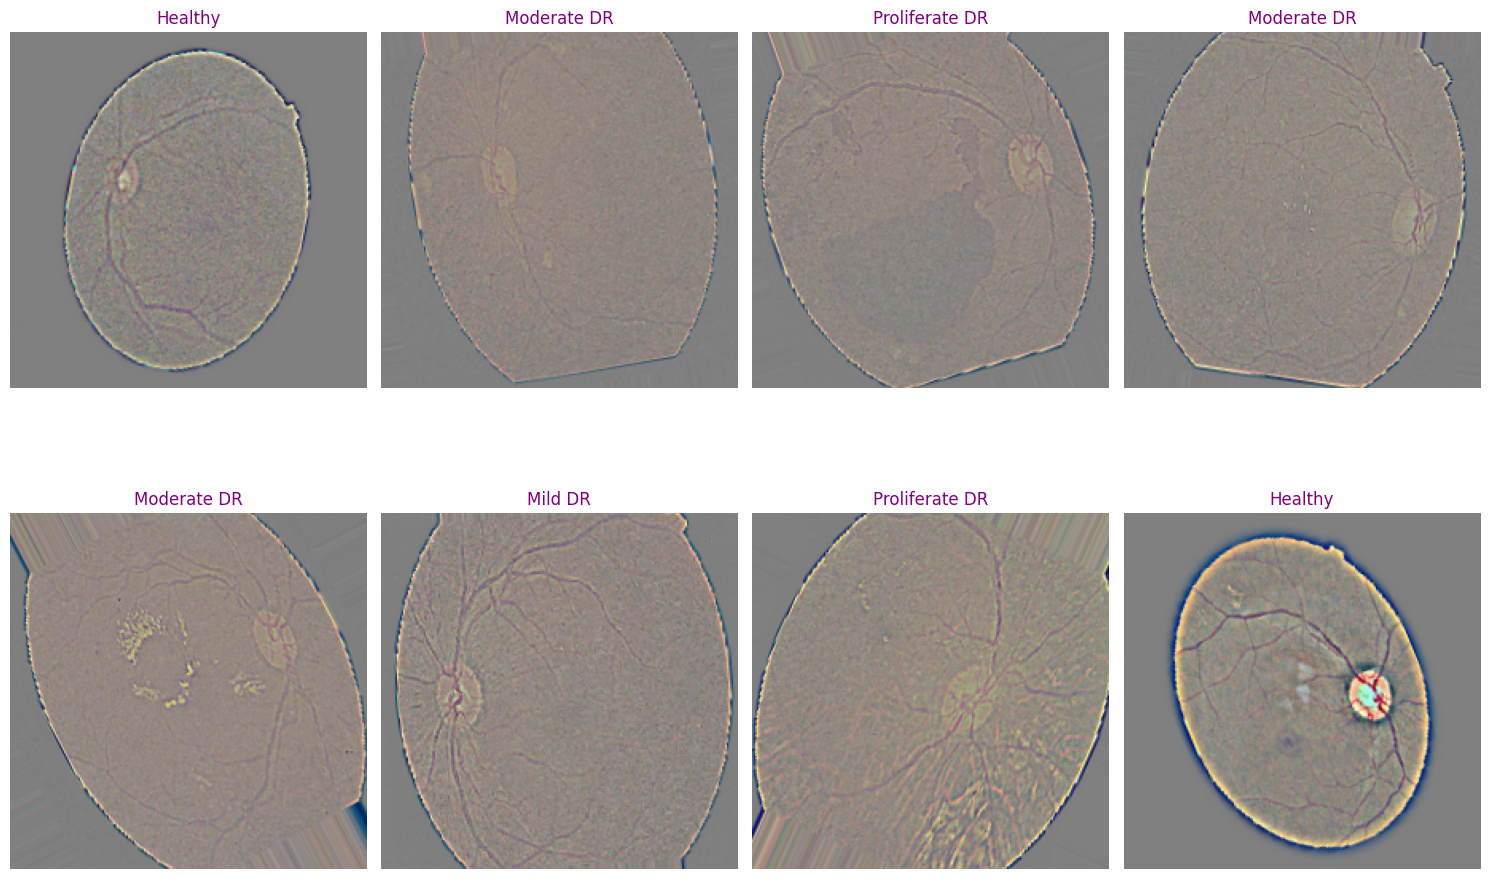

In [16]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Define number of classes
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(l1=0.005),
                bias_regularizer=regularizers.l1(l1=0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(l1=0.005),
                bias_regularizer=regularizers.l1(l1=0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l2 = 0.01),activity_regularizer=regularizers.l1(l1=0.005),
                bias_regularizer=regularizers.l1(l1=0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate

In [20]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [21]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,735,348 (44.77 MB)

 Trainable params: 11,648,045 (44.43 MB)

 Non-trainable params: 87,303 (341.03 KB)

## B- Visualize model layers

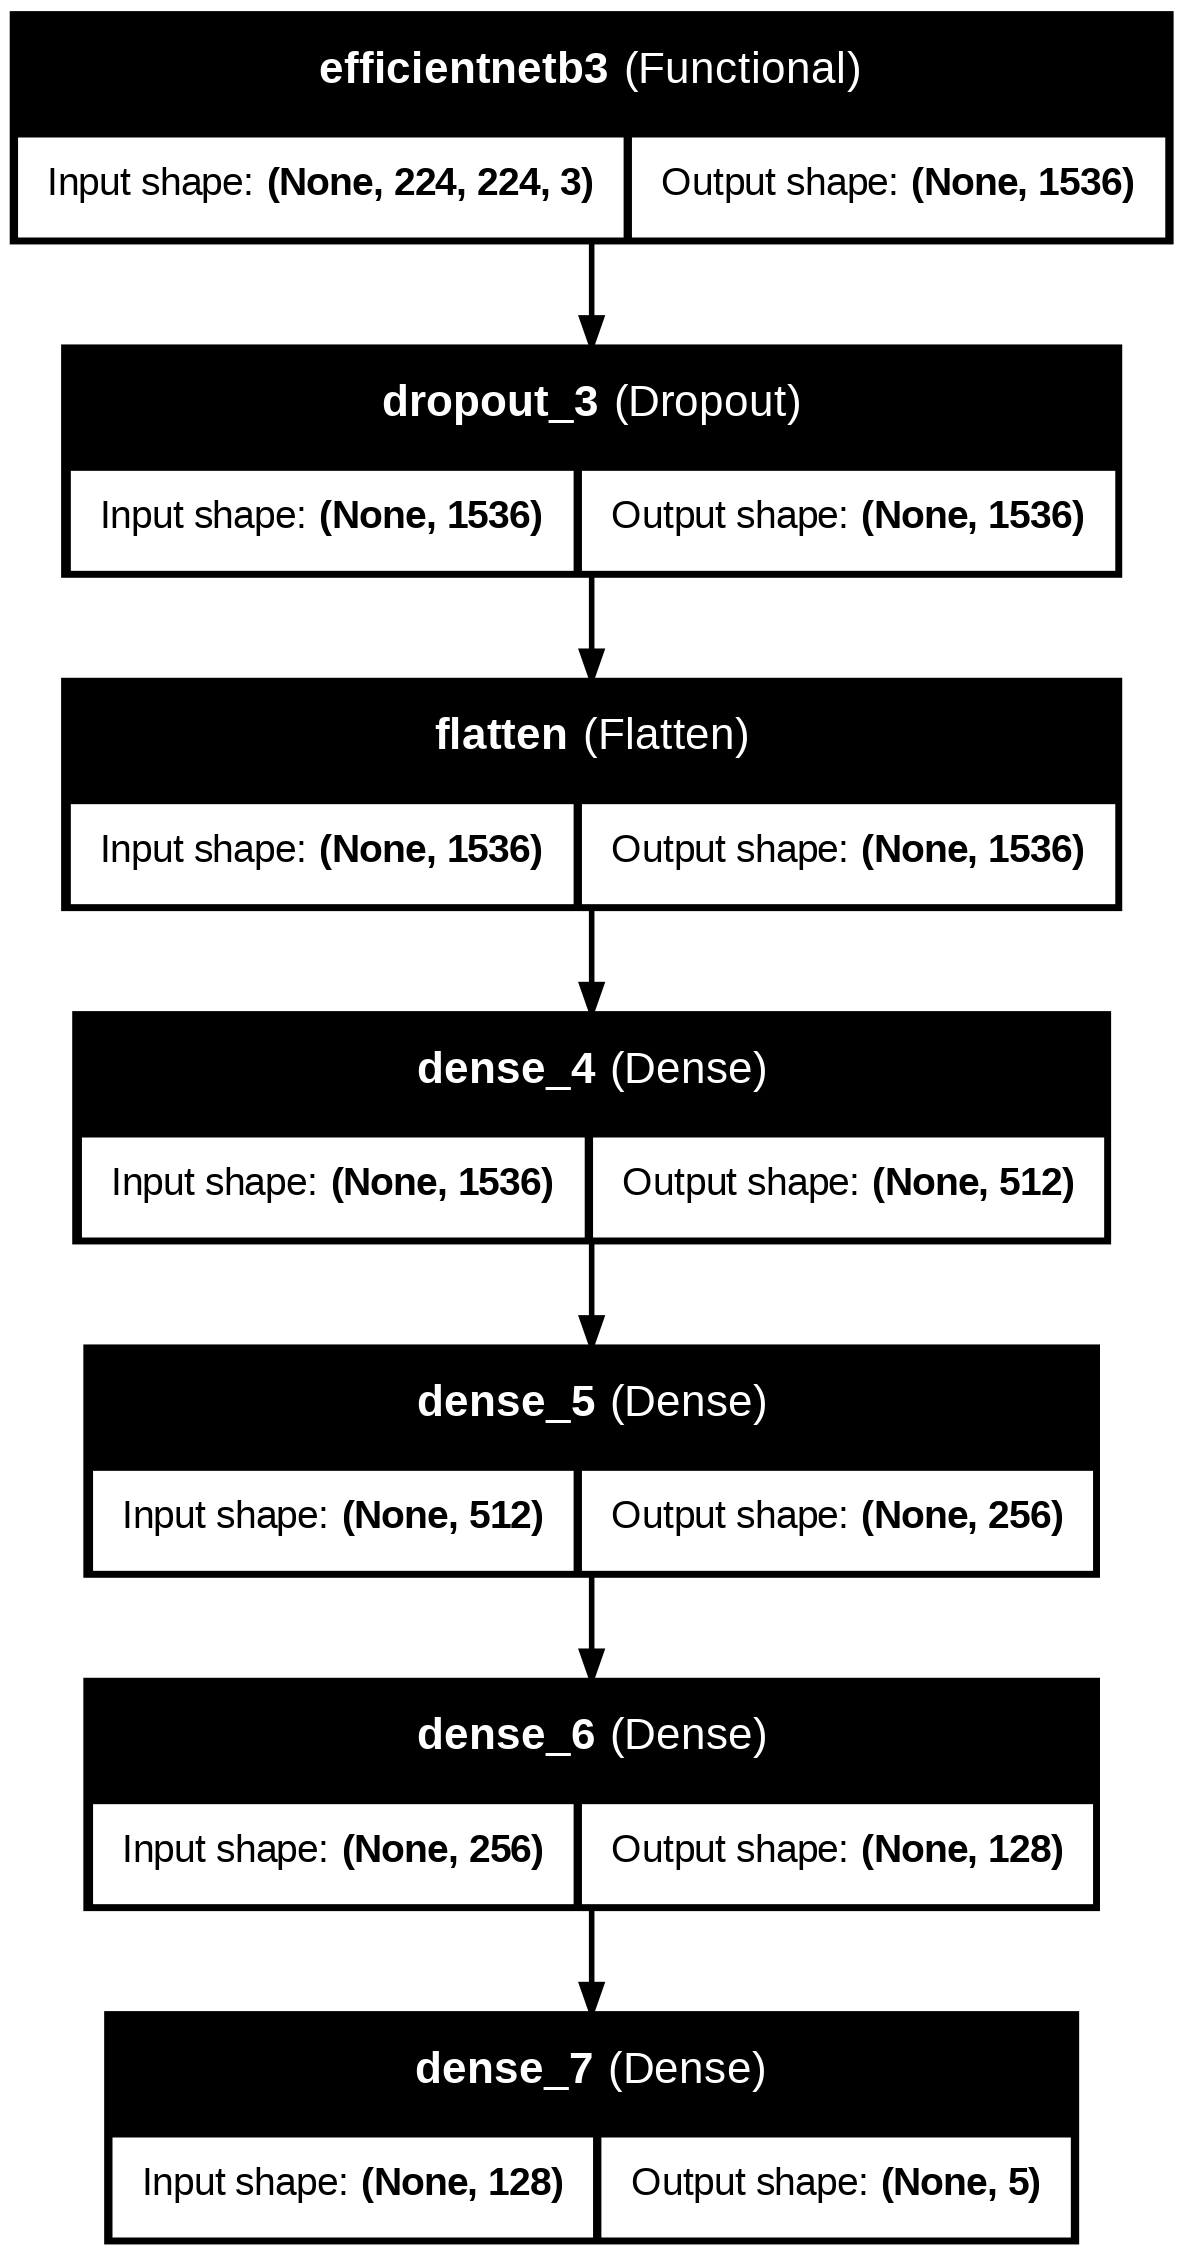

In [23]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [ ]:
epochs =50
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1124s 10s/step - acc: 0.4350 - loss: 2.0671 - val_acc: 0.4945 - val_loss: 1.4990
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 646s 6s/step - acc: 0.5293 - loss: 1.3583 - val_acc: 0.5891 - val_loss: 1.1248
Epoch 3/50


In [ ]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)


# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

In [ ]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

In [ ]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

In [ ]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices

# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

In [ ]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')

plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [ ]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))


In [ ]:
model.save('effB3 CNN DR.h5')